# GANomaly
- 2020.08.17 : gen 20/ lr 3e-2

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 3e-2

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 20)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3811 / DC_loss : 0.0418
- D(x):0.4996 / D(DC(z1)) : 0.4969 / D(DC(z2)) : 0.9590
[1/100][1/15]
- D_loss : 3.5128 / DC_loss : 1.6809
- D(x):0.7439 / D(DC(z1)) : 0.9591 / D(DC(z2)) : 0.1862
[1/100][2/15]
- D_loss : 3.0787 / DC_loss : 0.0006
- D(x):0.0652 / D(DC(z1)) : 0.1860 / D(DC(z2)) : 0.9994
[1/100][3/15]
- D_loss : 7.5147 / DC_loss : 0.1248
- D(x):0.9781 / D(DC(z1)) : 0.9994 / D(DC(z2)) : 0.8827
[1/100][4/15]
- D_loss : 3.1937 / DC_loss : 4.8738
- D(x):0.4186 / D(DC(z1)) : 0.8827 / D(DC(z2)) : 0.0076
[1/100][5/15]
- D_loss : 2.2774 / DC_loss : 1.0633
- D(x):0.1826 / D(DC(z1)) : 0.0076 / D(DC(z2)) : 0.3453
[1/100][6/15]
- D_loss : 0.7805 / DC_loss : 2.5625
- D(x):0.7375 / D(DC(z1)) : 0.3453 / D(DC(z2)) : 0.0771
[1/100][7/15]
- D_loss : 0.2163 / DC_loss : 3.8231
- D(x):0.8792 / D(DC(z1)) : 0.0771 / D(DC(z2)) : 0.0219
[1/100][8/15]
- D_loss : 0.0896 / DC_loss : 4.3200
- D(x):0.9417 / D(DC(z1)) : 0.0219 / D(DC(z2)) : 0.0133
[1/100][9/15]
- D_loss : 0.0370 / DC_

[6/100][2/15]
- D_loss : 0.0008 / DC_loss : 8.0035
- D(x):0.9995 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][3/15]
- D_loss : 0.0009 / DC_loss : 8.0329
- D(x):0.9994 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][4/15]
- D_loss : 0.0008 / DC_loss : 8.0592
- D(x):0.9995 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][5/15]
- D_loss : 0.0008 / DC_loss : 8.0875
- D(x):0.9996 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][6/15]
- D_loss : 0.0008 / DC_loss : 8.1161
- D(x):0.9995 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][7/15]
- D_loss : 0.0008 / DC_loss : 8.1411
- D(x):0.9995 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][8/15]
- D_loss : 0.0009 / DC_loss : 8.1601
- D(x):0.9994 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][9/15]
- D_loss : 0.0008 / DC_loss : 8.1800
- D(x):0.9995 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][10/15]
- D_loss : 0.0007 / DC_loss : 8.2018
- D(x):0.9996 / D(DC(z1)) : 0.0003 / D(DC(z2)) : 0.0003
[6/100][11/15]
- D_loss : 0.0013 / D

[11/100][4/15]
- D_loss : 0.0002 / DC_loss : 9.2269
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][5/15]
- D_loss : 0.0002 / DC_loss : 9.2489
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][6/15]
- D_loss : 0.0002 / DC_loss : 9.2701
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][7/15]
- D_loss : 0.0002 / DC_loss : 9.2901
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][8/15]
- D_loss : 0.0004 / DC_loss : 9.2949
- D(x):0.9997 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][9/15]
- D_loss : 0.0002 / DC_loss : 9.3092
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][10/15]
- D_loss : 0.0002 / DC_loss : 9.3276
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][11/15]
- D_loss : 0.0002 / DC_loss : 9.3457
- D(x):0.9999 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][12/15]
- D_loss : 0.0002 / DC_loss : 9.3585
- D(x):0.9998 / D(DC(z1)) : 0.0001 / D(DC(z2)) : 0.0001
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 0.0001 / DC_loss : 9.9930
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][6/15]
- D_loss : 0.0001 / DC_loss : 10.0048
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][7/15]
- D_loss : 0.0001 / DC_loss : 10.0140
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][8/15]
- D_loss : 0.0001 / DC_loss : 10.0237
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][9/15]
- D_loss : 0.0001 / DC_loss : 10.0371
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][10/15]
- D_loss : 0.0001 / DC_loss : 10.0514
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][11/15]
- D_loss : 0.0001 / DC_loss : 10.0590
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][12/15]
- D_loss : 0.0001 / DC_loss : 10.0705
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][13/15]
- D_loss : 0.0001 / DC_loss : 10.0826
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[16/100][14/15]


[21/100][5/15]
- D_loss : 0.0001 / DC_loss : 10.5619
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][6/15]
- D_loss : 0.0001 / DC_loss : 10.5697
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][7/15]
- D_loss : 0.0001 / DC_loss : 10.5777
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][8/15]
- D_loss : 0.0001 / DC_loss : 10.5863
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][9/15]
- D_loss : 0.0001 / DC_loss : 10.5954
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][10/15]
- D_loss : 0.0001 / DC_loss : 10.5987
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][11/15]
- D_loss : 0.0001 / DC_loss : 10.6035
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][12/15]
- D_loss : 0.0001 / DC_loss : 10.6113
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][13/15]
- D_loss : 0.0001 / DC_loss : 10.6174
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[21/100][14/15]

[26/100][5/15]
- D_loss : 0.0001 / DC_loss : 10.9413
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][6/15]
- D_loss : 0.0001 / DC_loss : 10.9429
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][7/15]
- D_loss : 0.0001 / DC_loss : 10.9356
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][8/15]
- D_loss : 0.0000 / DC_loss : 10.9250
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][9/15]
- D_loss : 0.0000 / DC_loss : 10.9437
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][10/15]
- D_loss : 0.0000 / DC_loss : 10.9618
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][11/15]
- D_loss : 0.0001 / DC_loss : 10.9467
- D(x):0.9999 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][12/15]
- D_loss : 0.0000 / DC_loss : 10.9641
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][13/15]
- D_loss : 0.0000 / DC_loss : 10.9699
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[26/100][14/15]

[31/100][5/15]
- D_loss : 0.0000 / DC_loss : 11.2744
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][6/15]
- D_loss : 0.0000 / DC_loss : 11.2711
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][7/15]
- D_loss : 0.0000 / DC_loss : 11.2723
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][8/15]
- D_loss : 0.0001 / DC_loss : 11.2794
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][9/15]
- D_loss : 0.0000 / DC_loss : 11.2773
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][10/15]
- D_loss : 0.0000 / DC_loss : 11.2656
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][11/15]
- D_loss : 0.0001 / DC_loss : 11.2380
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][12/15]
- D_loss : 0.0000 / DC_loss : 11.2742
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][13/15]
- D_loss : 0.0000 / DC_loss : 11.2838
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[31/100][14/15]

[36/100][5/15]
- D_loss : 0.0000 / DC_loss : 11.5573
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][6/15]
- D_loss : 0.0000 / DC_loss : 11.5595
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][7/15]
- D_loss : 0.0000 / DC_loss : 11.5624
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][8/15]
- D_loss : 0.0000 / DC_loss : 11.5674
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][9/15]
- D_loss : 0.0000 / DC_loss : 11.5694
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][10/15]
- D_loss : 0.0000 / DC_loss : 11.5717
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][11/15]
- D_loss : 0.0000 / DC_loss : 11.5625
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][12/15]
- D_loss : 0.0000 / DC_loss : 11.5661
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][13/15]
- D_loss : 0.0000 / DC_loss : 11.5874
- D(x):1.0000 / D(DC(z1)) : 0.0000 / D(DC(z2)) : 0.0000
[36/100][14/15]

[41/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[41/100][14/15]

[46/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[46/100][14/15]

[51/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[51/100][14/15]

[56/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[56/100][14/15]

[61/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[61/100][14/15]

[66/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[66/100][14/15]

[71/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[71/100][14/15]

[76/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[76/100][14/15]

[81/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[81/100][14/15]

[86/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[86/100][14/15]

[91/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[91/100][14/15]

[96/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][8/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][9/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][10/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][11/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][12/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][13/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[96/100][14/15]

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

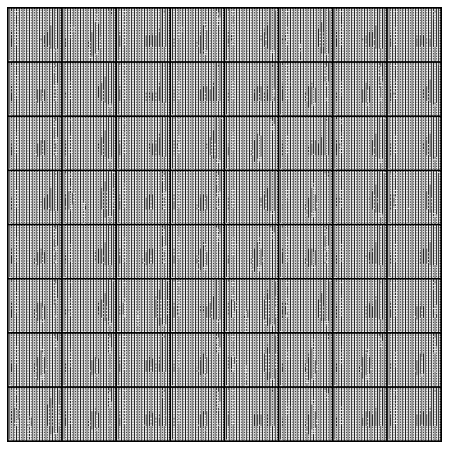

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 1.1709

[1/100][1/15]
- E_loss: 1.1539

[1/100][2/15]
- E_loss: 1.1711

[1/100][3/15]
- E_loss: 1.1622

[1/100][4/15]
- E_loss: 1.2008

[1/100][5/15]
- E_loss: 1.1530

[1/100][6/15]
- E_loss: 1.1425

[1/100][7/15]
- E_loss: 1.1408

[1/100][8/15]
- E_loss: 1.1526

[1/100][9/15]
- E_loss: 1.1398

[1/100][10/15]
- E_loss: 1.1721

[1/100][11/15]
- E_loss: 1.1497

[1/100][12/15]
- E_loss: 1.1870

[1/100][13/15]
- E_loss: 1.1548

[1/100][14/15]
- E_loss: 1.1542

[2/100][0/15]
- E_loss: 1.1368

[2/100][1/15]
- E_loss: 1.1317

[2/100][2/15]
- E_loss: 1.1472

[2/100][3/15]
- E_loss: 1.1481

[2/100][4/15]
- E_loss: 1.1552

[2/100][5/15]
- E_loss: 1.1474

[2/100][6/15]
- E_loss: 1.1750

[2/100][7/15]
- E_loss: 1.1736

[2/100][8/15]
- E_loss: 1.1488

[2/100][9/15]
- E_loss: 1.1431

[2/100][10/15]
- E_loss: 1.1723

[2/100][11/15]
- E_loss: 1.1700

[2/100][12/15]
- E_loss: 1.1399

[2/100][13/15]
- E_loss: 1.1884

[2/100][14/15]
- E_loss: 1.1775

[3/100][0/15]
- E_loss: 1.1412

[17/100][12/15]
- E_loss: 1.1445

[17/100][13/15]
- E_loss: 1.1299

[17/100][14/15]
- E_loss: 1.1662

[18/100][0/15]
- E_loss: 1.1245

[18/100][1/15]
- E_loss: 1.1551

[18/100][2/15]
- E_loss: 1.1539

[18/100][3/15]
- E_loss: 1.1484

[18/100][4/15]
- E_loss: 1.1807

[18/100][5/15]
- E_loss: 1.1779

[18/100][6/15]
- E_loss: 1.1262

[18/100][7/15]
- E_loss: 1.1429

[18/100][8/15]
- E_loss: 1.1240

[18/100][9/15]
- E_loss: 1.1815

[18/100][10/15]
- E_loss: 1.1406

[18/100][11/15]
- E_loss: 1.1339

[18/100][12/15]
- E_loss: 1.1558

[18/100][13/15]
- E_loss: 1.1452

[18/100][14/15]
- E_loss: 1.1779

[19/100][0/15]
- E_loss: 1.1495

[19/100][1/15]
- E_loss: 1.1609

[19/100][2/15]
- E_loss: 1.1815

[19/100][3/15]
- E_loss: 1.1589

[19/100][4/15]
- E_loss: 1.1327

[19/100][5/15]
- E_loss: 1.1341

[19/100][6/15]
- E_loss: 1.1622

[19/100][7/15]
- E_loss: 1.1120

[19/100][8/15]
- E_loss: 1.1435

[19/100][9/15]
- E_loss: 1.1242

[19/100][10/15]
- E_loss: 1.1437

[19/100][11/15]
- E_loss: 1.1453



[34/100][3/15]
- E_loss: 1.1474

[34/100][4/15]
- E_loss: 1.1546

[34/100][5/15]
- E_loss: 1.1774

[34/100][6/15]
- E_loss: 1.1620

[34/100][7/15]
- E_loss: 1.1486

[34/100][8/15]
- E_loss: 1.1458

[34/100][9/15]
- E_loss: 1.1397

[34/100][10/15]
- E_loss: 1.1757

[34/100][11/15]
- E_loss: 1.1446

[34/100][12/15]
- E_loss: 1.1440

[34/100][13/15]
- E_loss: 1.1484

[34/100][14/15]
- E_loss: 1.1421

[35/100][0/15]
- E_loss: 1.1445

[35/100][1/15]
- E_loss: 1.1281

[35/100][2/15]
- E_loss: 1.1467

[35/100][3/15]
- E_loss: 1.1522

[35/100][4/15]
- E_loss: 1.1537

[35/100][5/15]
- E_loss: 1.1594

[35/100][6/15]
- E_loss: 1.1461

[35/100][7/15]
- E_loss: 1.1617

[35/100][8/15]
- E_loss: 1.1402

[35/100][9/15]
- E_loss: 1.1480

[35/100][10/15]
- E_loss: 1.1628

[35/100][11/15]
- E_loss: 1.1606

[35/100][12/15]
- E_loss: 1.1603

[35/100][13/15]
- E_loss: 1.1388

[35/100][14/15]
- E_loss: 1.1501

[36/100][0/15]
- E_loss: 1.1201

[36/100][1/15]
- E_loss: 1.1658

[36/100][2/15]
- E_loss: 1.1479



[50/100][9/15]
- E_loss: 1.1537

[50/100][10/15]
- E_loss: 1.1572

[50/100][11/15]
- E_loss: 1.1570

[50/100][12/15]
- E_loss: 1.1253

[50/100][13/15]
- E_loss: 1.1691

[50/100][14/15]
- E_loss: 1.1554

[51/100][0/15]
- E_loss: 1.1614

[51/100][1/15]
- E_loss: 1.1607

[51/100][2/15]
- E_loss: 1.1353

[51/100][3/15]
- E_loss: 1.1212

[51/100][4/15]
- E_loss: 1.1400

[51/100][5/15]
- E_loss: 1.1376

[51/100][6/15]
- E_loss: 1.1625

[51/100][7/15]
- E_loss: 1.1742

[51/100][8/15]
- E_loss: 1.1474

[51/100][9/15]
- E_loss: 1.1613

[51/100][10/15]
- E_loss: 1.1291

[51/100][11/15]
- E_loss: 1.1557

[51/100][12/15]
- E_loss: 1.1738

[51/100][13/15]
- E_loss: 1.1513

[51/100][14/15]
- E_loss: 1.1593

[52/100][0/15]
- E_loss: 1.1367

[52/100][1/15]
- E_loss: 1.1851

[52/100][2/15]
- E_loss: 1.1566

[52/100][3/15]
- E_loss: 1.2003

[52/100][4/15]
- E_loss: 1.1461

[52/100][5/15]
- E_loss: 1.1345

[52/100][6/15]
- E_loss: 1.1706

[52/100][7/15]
- E_loss: 1.1319

[52/100][8/15]
- E_loss: 1.1397



[67/100][0/15]
- E_loss: 1.1300

[67/100][1/15]
- E_loss: 1.1377

[67/100][2/15]
- E_loss: 1.1742

[67/100][3/15]
- E_loss: 1.1523

[67/100][4/15]
- E_loss: 1.1957

[67/100][5/15]
- E_loss: 1.1553

[67/100][6/15]
- E_loss: 1.1496

[67/100][7/15]
- E_loss: 1.1226

[67/100][8/15]
- E_loss: 1.1499

[67/100][9/15]
- E_loss: 1.1569

[67/100][10/15]
- E_loss: 1.1283

[67/100][11/15]
- E_loss: 1.1701

[67/100][12/15]
- E_loss: 1.1237

[67/100][13/15]
- E_loss: 1.1858

[67/100][14/15]
- E_loss: 1.1540

[68/100][0/15]
- E_loss: 1.1716

[68/100][1/15]
- E_loss: 1.1631

[68/100][2/15]
- E_loss: 1.1280

[68/100][3/15]
- E_loss: 1.1739

[68/100][4/15]
- E_loss: 1.1631

[68/100][5/15]
- E_loss: 1.1294

[68/100][6/15]
- E_loss: 1.1598

[68/100][7/15]
- E_loss: 1.1622

[68/100][8/15]
- E_loss: 1.1632

[68/100][9/15]
- E_loss: 1.1472

[68/100][10/15]
- E_loss: 1.1342

[68/100][11/15]
- E_loss: 1.1482

[68/100][12/15]
- E_loss: 1.1389

[68/100][13/15]
- E_loss: 1.1258

[68/100][14/15]
- E_loss: 1.1501



[83/100][6/15]
- E_loss: 1.1765

[83/100][7/15]
- E_loss: 1.1625

[83/100][8/15]
- E_loss: 1.1577

[83/100][9/15]
- E_loss: 1.1796

[83/100][10/15]
- E_loss: 1.1251

[83/100][11/15]
- E_loss: 1.1832

[83/100][12/15]
- E_loss: 1.1339

[83/100][13/15]
- E_loss: 1.1415

[83/100][14/15]
- E_loss: 1.1334

[84/100][0/15]
- E_loss: 1.1779

[84/100][1/15]
- E_loss: 1.1684

[84/100][2/15]
- E_loss: 1.1341

[84/100][3/15]
- E_loss: 1.1315

[84/100][4/15]
- E_loss: 1.1543

[84/100][5/15]
- E_loss: 1.1417

[84/100][6/15]
- E_loss: 1.1488

[84/100][7/15]
- E_loss: 1.1478

[84/100][8/15]
- E_loss: 1.1526

[84/100][9/15]
- E_loss: 1.1264

[84/100][10/15]
- E_loss: 1.1520

[84/100][11/15]
- E_loss: 1.1720

[84/100][12/15]
- E_loss: 1.1578

[84/100][13/15]
- E_loss: 1.1237

[84/100][14/15]
- E_loss: 1.1563

[85/100][0/15]
- E_loss: 1.1352

[85/100][1/15]
- E_loss: 1.1492

[85/100][2/15]
- E_loss: 1.1419

[85/100][3/15]
- E_loss: 1.1637

[85/100][4/15]
- E_loss: 1.1813

[85/100][5/15]
- E_loss: 1.1413



[99/100][12/15]
- E_loss: 1.1764

[99/100][13/15]
- E_loss: 1.1653

[99/100][14/15]
- E_loss: 1.1541

[100/100][0/15]
- E_loss: 1.1464

[100/100][1/15]
- E_loss: 1.1356

[100/100][2/15]
- E_loss: 1.1641

[100/100][3/15]
- E_loss: 1.1747

[100/100][4/15]
- E_loss: 1.1514

[100/100][5/15]
- E_loss: 1.1495

[100/100][6/15]
- E_loss: 1.1737

[100/100][7/15]
- E_loss: 1.1840

[100/100][8/15]
- E_loss: 1.1635

[100/100][9/15]
- E_loss: 1.1546

[100/100][10/15]
- E_loss: 1.1315

[100/100][11/15]
- E_loss: 1.1303

[100/100][12/15]
- E_loss: 1.1495

[100/100][13/15]
- E_loss: 1.1169

[100/100][14/15]
- E_loss: 1.1389



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

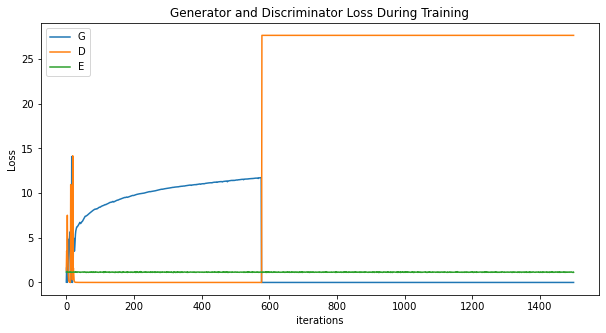

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

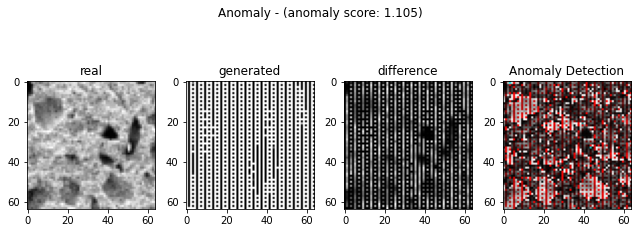

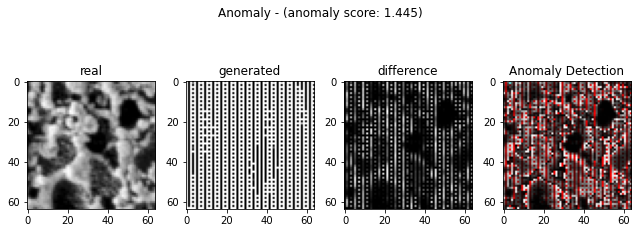

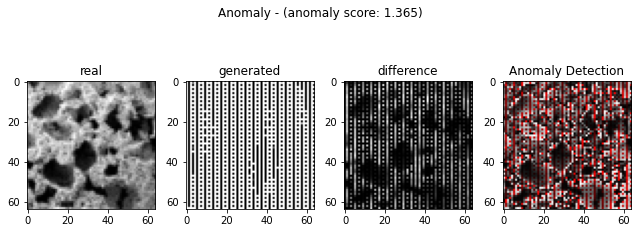

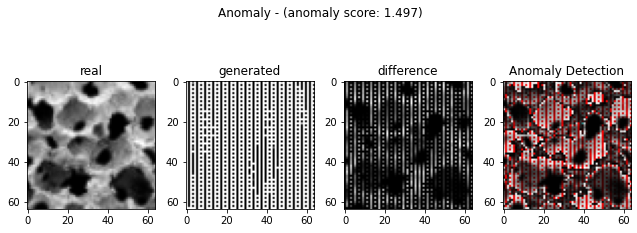

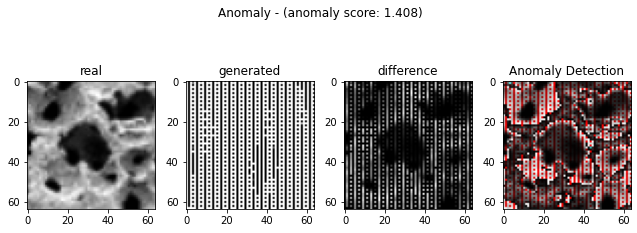

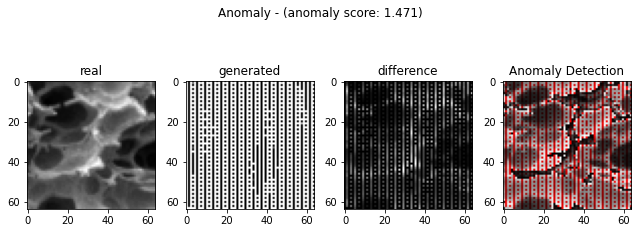

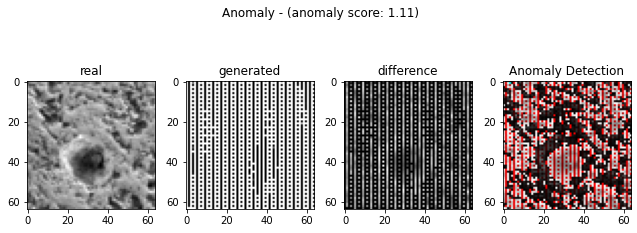

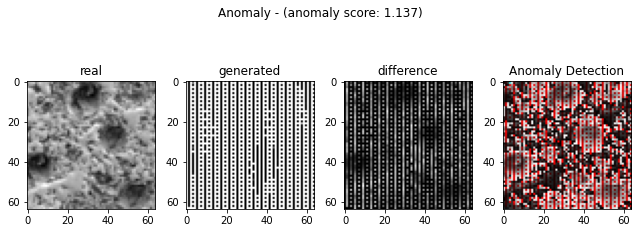

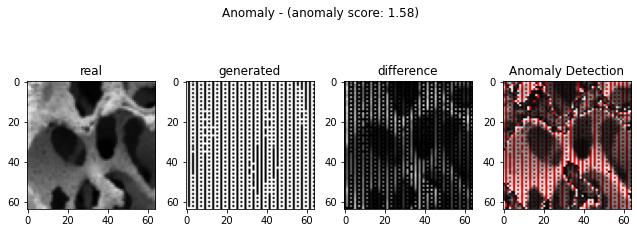

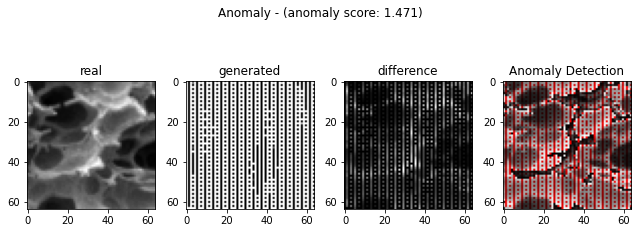

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.37744141 0.36767578 0.37670898 0.36035156 0.36669922 0.37646484
 0.37744141 0.37719727 0.37670898 0.37646484]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.3733154296875

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[-0.0037521292689523776, 0.013972602065531263, -0.0052651833507329476, 0.008653337406083213, -0.016650634572403317, -0.005419310299510734, -0.0037521292689523776, -0.0037864494402436322, -0.0037137407655136977, -0.005419310299510734]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:

def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

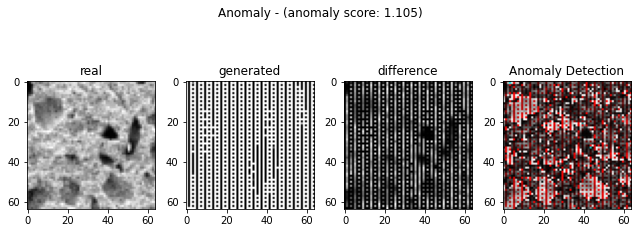

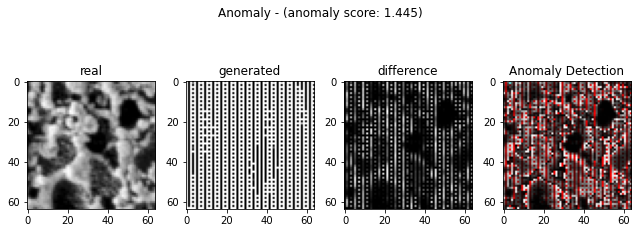

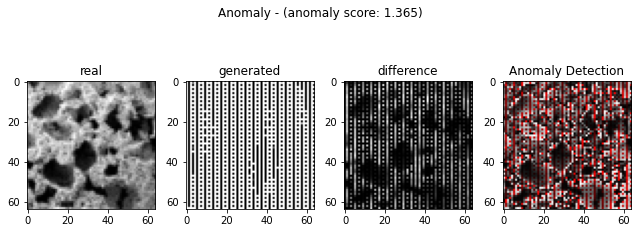

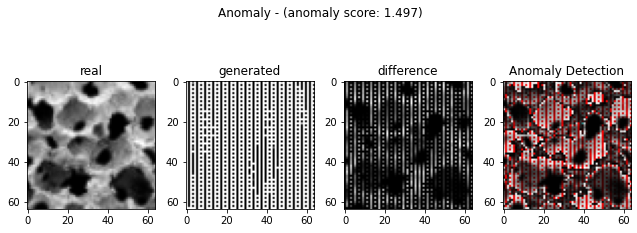

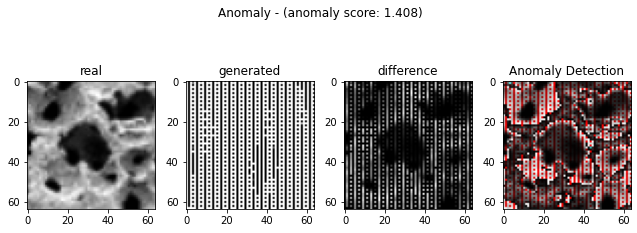

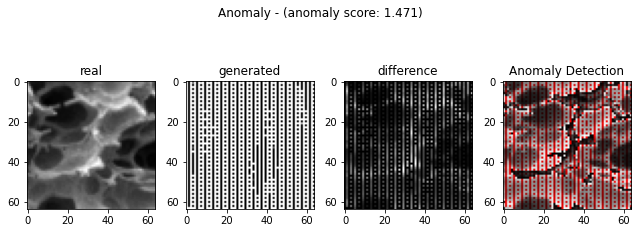

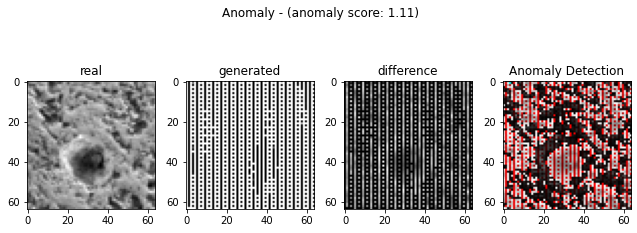

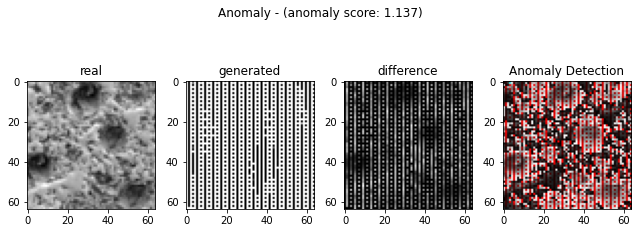

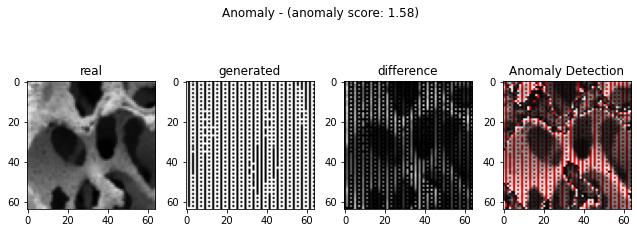

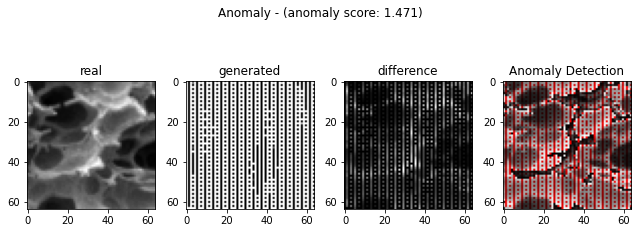

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.37744141 0.36767578 0.37670898 0.36035156 0.36669922 0.37646484
 0.37744141 0.37719727 0.37670898 0.37646484]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[-0.0037521292689523776, 0.013972602065531263, -0.0052651833507329476, 0.008653337406083213, -0.016650634572403317, -0.005419310299510734, -0.0037521292689523776, -0.0037864494402436322, -0.0037137407655136977, -0.005419310299510734]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [185,   1,   1],
         [113, 113, 113],
         ...,
         [ 51,   2,   2],
         [117, 117, 117],
         [111,   1,   1]],
 
        [[  5,   5,   5],
         [ 35,   1,   1],
         [204, 204, 204],
         ...,
         [ 49,   2,   2],
         [ 61,  61,  61],
         [ 53,  53,  53]],
 
        [[  7,   7,   7],
         [  9,   1,   1],
         [ 57,  57,  57],
         ...,
         [191,   1,   1],
         [238, 238, 238],
         [ 75,   1,   1]],
 
        ...,
 
        [[113, 113, 113],
         [157,   1,   1],
         [184, 184, 184],
         ...,
         [ 55,   2,   2],
         [ 45,  45,  45],
         [ 53,  53,  53]],
 
        [[132, 132, 132],
         [175,   1,   1],
         [202, 202, 202],
         ...,
         [245,   1,   1],
         [ 17,  17,  17],
         [ 41,   2,   2]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [161,   1,   1],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.67206543 1.62880371 1.6688208  1.59635742 1.62447754 1.66773926
 1.67206543 1.67098389 1.6688208  1.66773926]
